In [1]:
# Install the here package if you haven't already
if (!requireNamespace("here", quietly = TRUE)) {
  install.packages("here")
}

library(here)
source(here("WL_helperfuncs.r"), encoding = "UTF-8")


here() starts at C:/Users/mwiseman/Desktop/Micaela rTMS Project/Winterlight_GH



Load winterlight data

In [2]:
# Read and preprocess speech datasets
library(readxl)
library(dplyr)
library(readr)
library(tidyr)

# Read datasets
# Read and preprocess speech data
WL <- speech_read_and_preprocess(here("WINTERLIGHT_Sunnybrook_rTMS_2023_11_03.csv"))
WL_2 <- speech_read_and_preprocess(here("WINTERLIGHT_Sunnybrook_rTMSremote_2024_03_28.csv"))

# Apply filters
WL <- WL[grep("^(TMS|MDD|MFB|OCD)", WL$participant_external_id), ]
WL_2 <- WL_2[!(WL_2$participant_external_id == "TMS039" & WL_2$session_label %in% c("V2", "V3", "V4")), ]
WL_2 <- WL_2[!(WL_2$participant_external_id == "TMS039b" & WL_2$session_label == "V1"), ]
WL_2$participant_external_id[WL_2$session_label %in% c("V2", "V3") & WL_2$participant_external_id == "TMS039b"] <- "TMS039"

# Combine datasets
# Combine datasets
common_columns <- intersect(names(WL), names(WL_2))
WL_common <- WL[, common_columns]
WL_2_common <- WL_2[, common_columns]
WL_combined <- rbind(WL_common, WL_2_common)

# Processing participant_group
WL_combined$participant_group <- factor(
  ifelse(
    grepl("(^CTC|C_CTC)", WL_combined$participant_external_id), "Control",
    ifelse(grepl("^(TMS|MDD|MFB)", WL_combined$participant_external_id), "MDD",
    ifelse(grepl("^(OCD)", WL_combined$participant_external_id), "OCD",
    "Other" 
    )
  )
))

## Remove participants with high QIDS
high_qids <- c("CTC036", "CTC004", "CTC006", "CTC017", "CTC030", "CTC039", "CTC043", 
                    "CTC045", "CTC053", "CTC052", "CTC058", "CTC058_new", "CTC023", "CTB001", "CTC063", "CTC076")

# Filter rows to exclude those IDs
WL_filtered <- WL_combined %>%
  filter(!participant_external_id %in% high_qids)

# Remove participants with baseline data post TMS 
WL_combined <- WL_combined[!(WL_combined$participant_external_id == "TMS049" & WL_combined$session_label == "V1"), ]

# Define remote participants and assign testing location
remote_participants <- c(
    "CTC001", "CTC015", "CTC021", "CTC028", "CTC013", "CTC030",
    "CTC034", "CTC036", "CTC045", "TMS038")

# Function to identify CTC046 and higher
is_ctc046_or_higher <- function(id) {
  if (grepl("^CTC", id)) {
    # Extract the numeric part of the ID and check if it is 46 or higher
    num_part <- as.numeric(sub("^CTC", "", id))
    return(num_part >= 46)
  }
  FALSE
}

# Apply the function to all participants and get those that are CTC046 or higher
ctc046_or_higher <- sapply(WL_combined$participant_external_id, is_ctc046_or_higher)
additional_ctc <- WL_combined$participant_external_id[ctc046_or_higher]


# Function to identify TMS040 and higher
is_tms040_or_higher <- function(id) {
    if (grepl("^TMS", id)) {
        # Extract the numeric part of the ID and check if it is 46 or higher
        num_part <- as.numeric(sub("^TMS", "", id))
        return(num_part >= 40)
    }
    FALSE
}

# Apply the function to all participants and get those that are CTC046 or higher
tms040_or_higher <- sapply(WL_combined$participant_external_id, is_tms040_or_higher)
additional_tms <- WL_combined$participant_external_id[tms040_or_higher]

remote_participants <- c(remote_participants, additional_ctc, additional_tms)

WL_combined$testing_location <- ifelse(WL_combined$participant_external_id %in% remote_participants, 
                                       "remote", "in-person")
WL_combined$testing_location <- ifelse(WL_combined$participant_external_id %in% c("TMS052", "TMS053"), 
                                       "remote", WL_combined$testing_location)

                                 

# Replace values in session_label column
WL_combined$session_label <- gsub("Baseline", "V1", WL_combined$session_label)

str(WL_combined)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




'data.frame':	1355 obs. of  810 variables:
 $ X                                                          : int  1 2 3 4 5 6 7 8 9 10 ...
 $ sample_id                                                  : int  51341 51342 51343 51344 51345 51346 51347 51348 51349 52366 ...
 $ participant_external_id                                    : chr  "OCD108" "OCD108" "OCD108" "OCD108" ...
 $ task_name                                                  : chr  "paragraph_reading" "picture_description" "picture_description" "phonemic_fluency" ...
 $ session_label                                              : chr  "V1" "V1" "V1" "V1" ...
 $ sample_datetime_completed_utc                              : chr  "2021-12-16 17:41:38" "2021-12-16 17:42:55" "2021-12-16 17:44:07" "2021-12-16 17:45:58" ...
 $ stimulus_filename                                          : chr  "paragraph_03" "01_WinterLight_Family_in_the_kitchen_web.png" "02_WinterLight_Living_room_web.png" "en_v2_instructions_phonemic_fluency_f.m4a"

Journalling only, baseline, only MDD and controls 

In [3]:
WL_jou <-subset_by_task(WL_combined, "journaling")
WL_jou_bl <- subset_by_visit(WL_jou, "V1")
WL_jou_bl <-WL_jou_bl[WL_jou_bl$participant_group == "MDD"|WL_jou_bl$participant_group == "Control",]
str(WL_jou_bl)

'data.frame':	192 obs. of  810 variables:
 $ X                                                          : int  16 17 43 44 70 71 97 98 115 116 ...
 $ sample_id                                                  : int  52372 52373 52399 52400 52426 52427 53088 53089 53818 53819 ...
 $ participant_external_id                                    : chr  "TMS001" "TMS001" "TMS002" "TMS002" ...
 $ task_name                                                  : chr  "journaling" "journaling" "journaling" "journaling" ...
 $ session_label                                              : chr  "V1" "V1" "V1" "V1" ...
 $ sample_datetime_completed_utc                              : chr  "2022-01-04 16:09:55" "2022-01-04 16:10:17" "2022-01-04 15:55:47" "2022-01-04 15:56:21" ...
 $ stimulus_filename                                          : chr  "en_instruction_journal_feeling.mp3" "en_instruction_yesterday.mp3" "en_instruction_journal_feeling.mp3" "en_instruction_yesterday.mp3" ...
 $ terminal_state      

Remove columns with mostly or all NAs, 0 variance, and speech features irrelevant for connected speech (jitter, shimmer, hnr), or remote recording (mfccs subject to background noise)

- Set threshold to 25% for missing values 

In [4]:
cols_to_remove <- grep("^(jitter|shimmer|hnr|mfcc)", names(WL_jou_bl), value = TRUE)
cols_to_remove <- c(cols_to_remove, "X", "sample_id", "task_name", "session_label", "sample_datetime_completed_utc", "terminal_state")
WL_jou_bl <- WL_jou_bl[ , !(names(WL_jou_bl) %in% cols_to_remove)]

WL_jou_clean <- clean_dataframe(WL_jou_bl, na_threshold = 0.25)
head(WL_jou_clean)
write.csv(WL_jou_clean, "WL_jou_clean.csv", row.names = FALSE)

Columns with >= 25 % NAs: terminal_message MATTR_30 MATTR_40 MATTR_50 VERB_age_of_acquisition VERB_familiarity VERB_imageability cdr_name_address_correct_words_total cdr_name_address_correct_words_unique cdr_name_address_incorrect_words_total filled_pause_duration global_coherence_GloVe_100_avg_dist global_coherence_GloVe_100_max_dist global_coherence_GloVe_100_min_dist global_coherence_GloVe_200_avg_dist global_coherence_GloVe_200_max_dist global_coherence_GloVe_200_min_dist global_coherence_GloVe_300_avg_dist global_coherence_GloVe_300_max_dist global_coherence_GloVe_300_min_dist global_coherence_GloVe_50_avg_dist global_coherence_GloVe_50_max_dist global_coherence_GloVe_50_min_dist global_coherence_Google_300_avg_dist global_coherence_Google_300_max_dist global_coherence_Google_300_min_dist global_coherence_fastText_300_avg_dist global_coherence_fastText_300_max_dist global_coherence_fastText_300_min_dist info_units_bool_count info_units_bool_count_action info_units_bool_count_locat

,participant_external_id,stimulus_filename,tag_audio_quality,tag_background_noise,tag_participant_accent,tag_participant_clarity,tag_clinician_interference,tag_unsolicited_phi,ADJP_.._JJ,Lu_C,⋯,total_duration_speech,total_words,uh,unfilled_pauses,zcr_kurtosis,zcr_mean,zcr_skewness,zcr_var,participant_group,testing_location
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
16,TMS001,en_instruction_journal_feeling.mp3,0,1,1,1,1,0,0.037037037,1.500000,⋯,0.35793659,0.7241379,0.13793103,0.20689655,13.078970,0.05549323,3.883165,0.05241373,MDD,in-person
17,TMS001,en_instruction_yesterday.mp3,1,1,1,1,1,0,0.000000000,1.500000,⋯,0.08849558,0.7727273,0.09090909,0.13636364,16.251423,0.04716553,4.272168,0.04494095,MDD,in-person
43,TMS002,en_instruction_journal_feeling.mp3,0,0,0,1,0,0,0.006622517,2.333333,⋯,0.94801755,1.0208333,0.01388889,0.04861111,9.879678,0.06753448,3.446691,0.06297357,MDD,in-person
44,TMS002,en_instruction_yesterday.mp3,1,1,0,0,0,0,0.000000000,1.100000,⋯,0.84294310,0.9354839,0.04301075,0.04301075,9.409625,0.06976112,3.377814,0.06489450,MDD,in-person
70,TMS003,en_instruction_journal_feeling.mp3,0,1,0,1,0,0,0.027777778,1.666667,⋯,0.50809324,0.9000000,0.06666667,0.13333333,10.375047,0.06533752,3.517819,0.06106853,MDD,in-person
71,TMS003,en_instruction_yesterday.mp3,0,1,0,1,0,0,0.000000000,1.000000,⋯,0.32183100,0.9285714,0.03571429,0.03571429,11.060361,0.06252475,3.613912,0.05861541,MDD,in-person


Remove participants with mostly NAs

In [5]:
# threshold for missing data
threshold <-ncol(WL_jou_clean)/2
rows_with_majority_NA <- apply(WL_jou_clean, 1, function(x) sum(is.na(x)) > threshold)
# extract participant IDs for these rows 
ids_with_majority_NA <- WL_jou_clean$participant_external_id[rows_with_majority_NA]
#print the ids that will be removed
print(ids_with_majority_NA)
# remove rows with maj NA
WL_jou_clean <- WL_jou_clean[!rows_with_majority_NA, ]





[1] "CTC023" "CTC023" "TMS053" "TMS055" "TMS055"


In [20]:
# Identify missing values per column
missing_values_summary <- sapply(WL_jou_clean, function(x) sum(is.na(x)))
missing_values_summary <- missing_values_summary[missing_values_summary > 0]
cat("Missing values per column:\n")
print(missing_values_summary)

# Verify that the summary shows correct information
if(all(missing_values_summary == 0)) {
  cat("No missing values found in any column.\n")
} else {
  cat("Missing values found in the dataset.\n")
}

# Find rows with any missing value
rows_with_na <- apply(WL_jou_clean, 1, function(x) any(is.na(x)))

# Extract data for rows with missing values
data_with_na <- WL_jou_clean[rows_with_na, ]

# Count the number of NAs in each row of the subset
data_with_na$na_count <- rowSums(is.na(data_with_na))

# Print rows (participants) with missing values and their count of NAs
cat("Participants with missing values and their NA counts:\n")
print(data_with_na[, c("participant_external_id", "na_count")])


Missing values per column:
                               MATTR_10                                MATTR_20 
                                     13                                      32 
                NOUN_age_of_acquisition                        NOUN_familiarity 
                                     32                                      32 
                         NOUN_frequency                       NOUN_imageability 
                                     17                                      32 
                 NOUN_sentiment_arousal                NOUN_sentiment_dominance 
                                     19                                      19 
                 NOUN_sentiment_valence                          VERB_frequency 
                                     19                                       3 
                 VERB_sentiment_arousal                VERB_sentiment_dominance 
                                      3                                       3 
 

Participants with missing values and their NA counts:
     participant_external_id na_count
16                    TMS001        8
17                    TMS001        1
70                    TMS003        1
97                    TMS004        9
98                    TMS004        3
115                   TMS005       24
169                   TMS007        1
259                   TMS011        7
260                   TMS011        1
286                   TMS013        3
322                   MDD103        1
323                   MDD103        1
340                   TMS016       33
358                   TMS018        8
359                   TMS018        2
376                   TMS020       22
394                   TMS019       13
395                   TMS019        2
428                   TMS022        6
446                   TMS023        4
473                   TMS024        1
491                   TMS026        9
519                   TMS027        1
545                   TMS029      

In [6]:
# Replace positive infinity values with NA
WL_jou_clean[WL_jou_clean == Inf] <- NA

# Replace negative infinity values with NA
WL_jou_clean[WL_jou_clean == -Inf] <- NA

head(WL_jou_clean)

,participant_external_id,stimulus_filename,tag_audio_quality,tag_background_noise,tag_participant_accent,tag_participant_clarity,tag_clinician_interference,tag_unsolicited_phi,ADJP_.._JJ,Lu_C,⋯,total_duration_speech,total_words,uh,unfilled_pauses,zcr_kurtosis,zcr_mean,zcr_skewness,zcr_var,participant_group,testing_location
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
16,TMS001,en_instruction_journal_feeling.mp3,0,1,1,1,1,0,0.037037037,1.500000,⋯,0.35793659,0.7241379,0.13793103,0.20689655,13.078970,0.05549323,3.883165,0.05241373,MDD,in-person
17,TMS001,en_instruction_yesterday.mp3,1,1,1,1,1,0,0.000000000,1.500000,⋯,0.08849558,0.7727273,0.09090909,0.13636364,16.251423,0.04716553,4.272168,0.04494095,MDD,in-person
43,TMS002,en_instruction_journal_feeling.mp3,0,0,0,1,0,0,0.006622517,2.333333,⋯,0.94801755,1.0208333,0.01388889,0.04861111,9.879678,0.06753448,3.446691,0.06297357,MDD,in-person
44,TMS002,en_instruction_yesterday.mp3,1,1,0,0,0,0,0.000000000,1.100000,⋯,0.84294310,0.9354839,0.04301075,0.04301075,9.409625,0.06976112,3.377814,0.06489450,MDD,in-person
70,TMS003,en_instruction_journal_feeling.mp3,0,1,0,1,0,0,0.027777778,1.666667,⋯,0.50809324,0.9000000,0.06666667,0.13333333,10.375047,0.06533752,3.517819,0.06106853,MDD,in-person
71,TMS003,en_instruction_yesterday.mp3,0,1,0,1,0,0,0.000000000,1.000000,⋯,0.32183100,0.9285714,0.03571429,0.03571429,11.060361,0.06252475,3.613912,0.05861541,MDD,in-person


Random forest baseline, all task files, no feature selection, imputation directly within the model (KNN)

Loading required package: ggplot2

Loading required package: lattice

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr':

    combine


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC: 0.753571428571429"
Confusion Matrix and Statistics

          Reference
Prediction MDD Control
   MDD      26      10
   Control   9      10
                                          
               Accuracy : 0.6545          
                 95% CI : (0.5142, 0.7776)
    No Information Rate : 0.6364          
    P-Value [Acc > NIR] : 0.4493          
                                          
                  Kappa : 0.2455          
                                          
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.7429          
            Specificity : 0.5000          
         Pos Pred Value : 0.7222          
         Neg Pred Value : 0.5263          
             Prevalence : 0.6364          
         Detection Rate : 0.4727          
   Detection Prevalence : 0.6545          
      Balanced Accuracy : 0.6214          
                                          
       'Positive' Class : MDD   

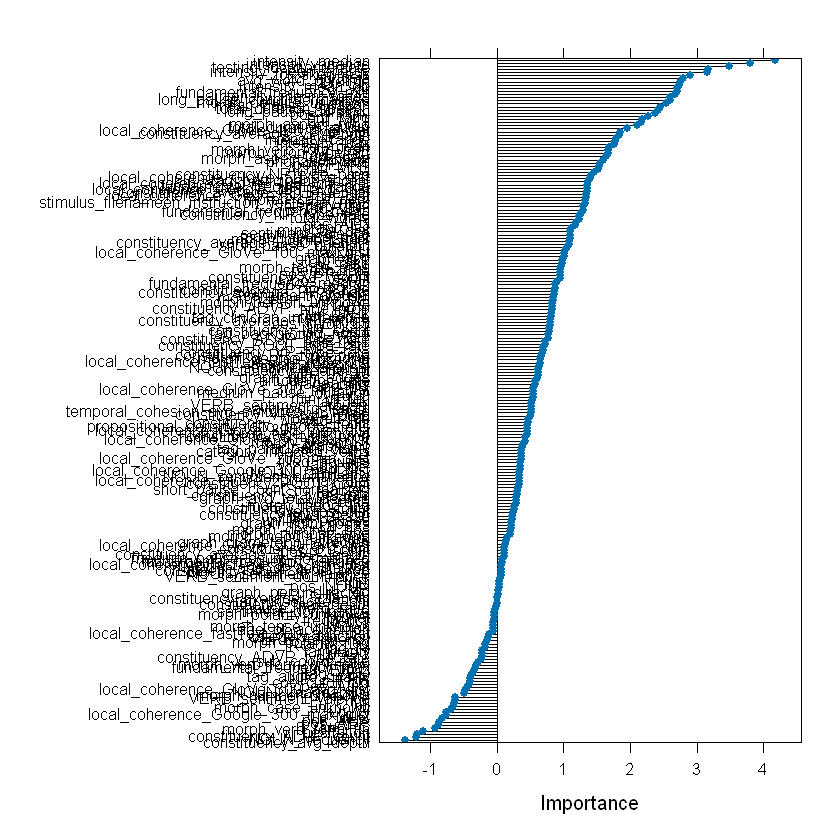

In [21]:
library(caret)
library(randomForest)
library(RANN)
library(pROC)

# Set a seed for reproducibility
set.seed(123)

# Ensure the target variable is a factor and drop levels with no data
WL_jou_clean$participant_group <- factor(WL_jou_clean$participant_group)
WL_jou_clean$participant_group <- droplevels(WL_jou_clean$participant_group)

# Replace Inf values with NA for imputation in numeric columns
WL_jou_clean <- data.frame(lapply(WL_jou_clean, function(x) {
  if(is.numeric(x)) { x[is.infinite(x)] <- NA }
  return(x)
}))

# Preprocess data: center, scale, and impute missing values
preProcModel <- preProcess(WL_jou_clean, method = c("center", "scale", "knnImpute"))
WL_jou_clean_preprocessed <- predict(preProcModel, WL_jou_clean)

# Split the preprocessed dataset into training and testing sets
trainIndex <- createDataPartition(WL_jou_clean_preprocessed$participant_group, p = 0.7, list = FALSE)
trainData <- WL_jou_clean_preprocessed[trainIndex, ]
testData <- WL_jou_clean_preprocessed[-trainIndex, ]

# Remove 'participant_external_id' column if it exists
trainData <- trainData[, !names(trainData) %in% c("participant_external_id")]
testData <- testData[, !names(testData) %in% c("participant_external_id")]

# Train the model with Random Forest
fitControl <- trainControl(method = "repeatedcv", number = 10, repeats = 5, classProbs = TRUE, summaryFunction = twoClassSummary)
rfFit <- train(participant_group ~ ., data = trainData, method = "rf", 
               trControl = fitControl, ntree = 500, metric = "ROC", 
               importance = TRUE) # Enable variable importance calculation## Importance = TRUE to calculate variable importance

# Extract variable importance
varImportance <- varImp(rfFit, scale = FALSE) # scale = FALSE to show the raw importance scores
# Plot variable importance
plot(varImportance)


# Predict on the testing set with class probabilities
predictions <- predict(rfFit, newdata = testData, type="prob")

# Calculate AUC for the positive class 'MDD'
rocResponse <- roc(response = as.numeric(testData$participant_group) - 1, predictor = predictions$MDD)
aucValue <- auc(rocResponse)
print(paste("AUC:", aucValue))



# Convert binary predictions and the test data's participant_group to factors with the same levels
binaryPredictions <- ifelse(predictions$MDD > 0.5, "MDD", "Control")
binaryPredictions <- factor(binaryPredictions, levels = c("MDD", "Control"))
testData$participant_group <- factor(testData$participant_group, levels = c("MDD", "Control"))

# Generate and print confusion matrix
confMatrix <- confusionMatrix(binaryPredictions, testData$participant_group)
print(confMatrix)



In [40]:
# Print the entire variable importance object
print(varImportance) # gives mean gini decrease

# Or convert to a data frame for easier viewing
varImp_df <- as.data.frame(varImportance$importance)

write.csv(varImp_df, "variable_importance_scores.csv", row.names = TRUE)



rf variable importance

  only 20 most important variables shown (out of 218)

                             Importance
fundamental_frequency_mean        7.839
fundamental_frequency_median      5.420
zcr_kurtosis                      3.132
zcr_mean                          2.853
intensity_variance                2.608
articulation_rate                 2.480
zcr_skewness                      2.149
tag_CC                            2.093
graph_lsc                         2.078
testing_locationremote            1.948
morph_aspect_prog                 1.920
pos_AUX                           1.795
tag_VBG                           1.764
morph_number_sing                 1.729
zcr_var                           1.649
intensity_range                   1.599
mean_pause_duration               1.566
intensity_max                     1.517
Lu_DC.C                           1.476
intensity_mean_sones              1.436


Random forest baseline, "feeling file", no feature selection

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC: 0.866666666666667"
Confusion Matrix and Statistics

          Reference
Prediction MDD Control
   MDD      15       4
   Control   0       0
                                          
               Accuracy : 0.7895          
                 95% CI : (0.5443, 0.9395)
    No Information Rate : 0.7895          
    P-Value [Acc > NIR] : 0.6297          
                                          
                  Kappa : 0               
                                          
 Mcnemar's Test P-Value : 0.1336          
                                          
            Sensitivity : 1.0000          
            Specificity : 0.0000          
         Pos Pred Value : 0.7895          
         Neg Pred Value :    NaN          
             Prevalence : 0.7895          
         Detection Rate : 0.7895          
   Detection Prevalence : 1.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : MDD   

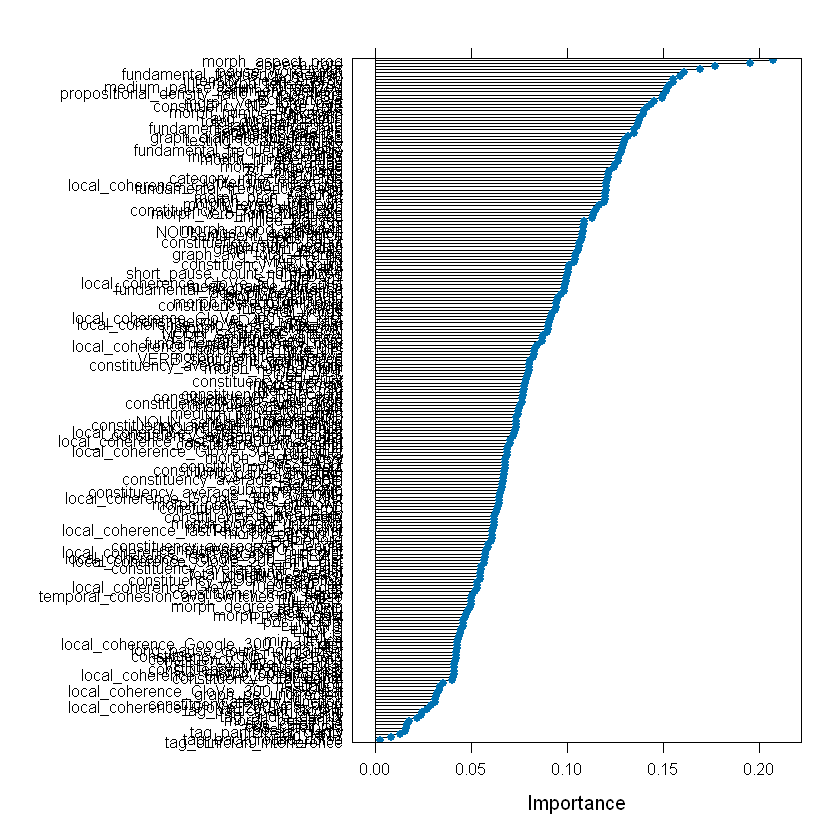

In [7]:
library(caret)
library(randomForest)
library(RANN)
library(pROC)

# Set a seed for reproducibility
set.seed(123)

#only feeling
WL_jou_feeling <- WL_jou_clean[WL_jou_clean$stimulus_filename == "en_instruction_journal_feeling.mp3",]
# Identify and remove zero-variance variables
nzv <- nearZeroVar(WL_jou_feeling, saveMetrics = TRUE)
WL_jou_feeling <- WL_jou_feeling[, !nzv$nzv]

# Ensure the target variable is a factor and drop levels with no data
WL_jou_feeling$participant_group <- factor(WL_jou_feeling$participant_group)
WL_jou_feeling$participant_group <- droplevels(WL_jou_feeling$participant_group)

# Replace Inf values with NA for imputation in numeric columns
WL_jou_feeling <- data.frame(lapply(WL_jou_feeling, function(x) {
  if(is.numeric(x)) { x[is.infinite(x)] <- NA }
  return(x)
}))

# Preprocess data: center, scale, and impute missing values
preProcModel <- preProcess(WL_jou_feeling, method = c("center", "scale", "knnImpute"))
WL_jou_clean_preprocessed <- predict(preProcModel, WL_jou_feeling)

# Split the preprocessed dataset into training and testing sets
trainIndex <- createDataPartition(WL_jou_clean_preprocessed$participant_group, p = 0.7, list = FALSE)
trainData <- WL_jou_clean_preprocessed[trainIndex, ]
testData <- WL_jou_clean_preprocessed[-trainIndex, ]


# Remove 'participant_external_id' column if it exists
trainData <- trainData[, !names(trainData) %in% c("participant_external_id")]
testData <- testData[, !names(testData) %in% c("participant_external_id")]

# Train the model with Random Forest
fitControl <- trainControl(method = "repeatedcv", number = 10, repeats = 5, classProbs = TRUE, summaryFunction = twoClassSummary)
rfFit <- train(participant_group ~ ., data = trainData, method = "rf", trControl = fitControl, ntree = 500, metric = "ROC")

# Extract variable importance
varImportance <- varImp(rfFit, scale = FALSE) # scale = FALSE to show the raw importance scores
# Plot variable importance
plot(varImportance)

# Predict on the testing set with class probabilities
predictions <- predict(rfFit, newdata = testData, type="prob")

# Calculate AUC for the positive class 'MDD'
rocResponse <- roc(response = as.numeric(testData$participant_group) - 1, predictor = predictions$MDD)
aucValue <- auc(rocResponse)
print(paste("AUC:", aucValue))

# Create binary predictions based on the probability of being in the "MDD" class
# Assuming a threshold of 0.5 to decide between classes
binaryPredictions <- ifelse(predictions$MDD > 0.5, "MDD", "Control")

# Now that we have binary predictions, we convert it to a factor with the same levels as the original target variable
binaryPredictions <- factor(binaryPredictions, levels = c("MDD","Control"))

# Ensure that the testData's participant_group is a factor with the expected levels
testData$participant_group <- factor(testData$participant_group, levels = c("MDD", "Control"))

# Generate and print confusion matrix
confMatrix <- confusionMatrix(binaryPredictions, testData$participant_group)
print(confMatrix)


In [44]:
# Print the entire variable importance object
print(varImportance) # gives mean gini decrease

# Or convert to a data frame for easier viewing
varImp_df <- as.data.frame(varImportance$importance)

write.csv(varImp_df, "variable_importance_scores.csv", row.names = TRUE)

rf variable importance

  only 20 most important variables shown (out of 216)

                                         Overall
morph_aspect_prog                         0.2074
speech_rate                               0.1951
zcr_var                                   0.1770
pause_word_ratio                          0.1694
fundamental_frequency_median              0.1611
pos_ADV                                   0.1591
intensity_mean_energy                     0.1554
morph_tense_pres                          0.1552
medium_pause_count_normalized             0.1533
sentiment_arousal                         0.1524
propositional_density_ratio_propositions  0.1516
tag_VBG                                   0.1502
zcr_kurtosis                              0.1495
morph_verb_form_part                      0.1452
constituency_NP_type_rate                 0.1437
pos_AUX                                   0.1418
morph_number_unknown                      0.1399
prp_ratio                              

MICE imputation first 

In [21]:
if (!requireNamespace("mice", quietly = TRUE)) install.packages("mice")
library(mice)

new_method_list <- mice_mod$method
new_method_list["graph_lcc"] <- "pmm"
mice_mod <- mice(WL_jou_clean, method = new_method_list, m = 5, maxit = 5, seed = 123)

# 'pmm' stands for predictive mean matching, a robust method for numeric data
# m = 5 specifies the number of multiple imputations (datasets) to create
# maxit = 5 specifies the number of iterations for each variable's imputation model



 iter imp variable
  1   1  MATTR_10*  MATTR_20*  NOUN_age_of_acquisition*  NOUN_familiarity*  NOUN_frequency*  NOUN_imageability*  NOUN_sentiment_arousal*  NOUN_sentiment_dominance*  NOUN_sentiment_valence*  VERB_frequency*  VERB_sentiment_arousal*  VERB_sentiment_dominance*  VERB_sentiment_valence*  age_of_acquisition*  ave_cos_dist*  familiarity*  graph_asp*  graph_avg_total_degree*  graph_diameter_undirected*  graph_lsc*  graph_num_edges*  graph_pe_undirected*  honore*  imageability*  local_coherence_GloVe_100_avg_dist*  local_coherence_GloVe_100_max_dist*  local_coherence_GloVe_100_min_dist  local_coherence_GloVe_200_avg_dist*  local_coherence_GloVe_200_max_dist*  local_coherence_GloVe_200_min_dist  local_coherence_GloVe_300_avg_dist*  local_coherence_GloVe_300_max_dist*  local_coherence_GloVe_300_min_dist*  local_coherence_GloVe_50_avg_dist*  local_coherence_GloVe_50_max_dist*  local_coherence_GloVe_50_min_dist*  local_coherence_Google_300_avg_dist*  local_coherence_Google_300_m

Warning message:
"Number of logged events: 2502"


In [22]:
# Example: Check for missing values in the first completed dataset
complete_data <- complete(mice_mod, 1)
any(is.na(complete_data))
colnames(complete_data)[colSums(is.na(complete_data)) > 0]
# Check the method used for each variable in the mice model
mice_mod$method['graph_lcc']



[1] TRUE

[1] "graph_lcc"

graph_lcc 
       ""

In [9]:
library(caret)
library(randomForest)
library(RANN)
library(pROC)

# Set a seed for reproducibility
set.seed(123)

library(mice)
library(caret)
library(randomForest)
library(pROC)

# Assuming mice_mod is already created as a mids object

# Placeholder for the ensemble of predictions across all imputations
all_predictions <- list()

# Number of imputations to loop through
m <- mice_mod$m

for (i in 1:m) {
  # Extract the ith imputed dataset
  imp_data <- complete(mice_mod, action = i)
  
  # Preprocess data: center, scale, and impute missing values (if necessary, adjust as per dataset requirements)
  preProcModel <- preProcess(imp_data, method = c("center", "scale"))
  imp_data_preprocessed <- predict(preProcModel, imp_data)
  
  # Split the preprocessed dataset into training and testing sets
  # Ensure your createDataPartition call and the rest of the code below this comment are using imp_data_preprocessed
  trainIndex <- createDataPartition(imp_data_preprocessed$participant_group, p = 0.7, list = FALSE)
  trainData <- imp_data_preprocessed[trainIndex, ]
  testData <- imp_data_preprocessed[-trainIndex, ]
  
  # Train the model with Random Forest
  fitControl <- trainControl(method = "repeatedcv", number = 10, repeats = 5, classProbs = TRUE, summaryFunction = twoClassSummary)
  rfFit <- train(participant_group ~ ., data = trainData, method = "rf", 
                 trControl = fitControl, ntree = 500, metric = "ROC", 
                 importance = TRUE)

  # Predict on the testing set with class probabilities for the current imputation
  predictions <- predict(rfFit, newdata = testData, type = "prob")
  
  # Store predictions
  all_predictions[[i]] <- predictions
}

# Assuming binary classification, adjust for more classes or regression
# Average the probabilities across all imputed datasets
avg_predictions <- do.call("cbind", all_predictions) %>% rowMeans()

# Assuming "MDD" is the positive class and you have its probabilities
# Convert averaged probabilities to binary predictions
final_predictions <- ifelse(avg_predictions > 0.5, "MDD", "Control")
final_predictions <- factor(final_predictions, levels = c("MDD", "Control"))

# Assuming testData$participant_group has the true labels for the last imputed dataset used for prediction
# For a more robust approach, you might want to ensure testData labels are consistent across imputations
testData$participant_group <- factor(testData$participant_group, levels = c("MDD", "Control"))

# Generate and print confusion matrix for averaged predictions
confMatrix <- confusionMatrix(final_predictions, testData$participant_group)
print(confMatrix)

# Calculate AUC for the positive class 'MDD' using the averaged predictions
rocResponse <- roc(response = as.numeric(testData$participant_group) - 1, predictor = avg_predictions)
aucValue <- auc(rocResponse)
print(paste("AUC:", aucValue))


Warning message in createDataPartition(imp_data_preprocessed$participant_group, :
"Some classes have no records ( OCD, Other ) and these will be ignored"


ERROR: Error in na.fail.default(structure(list(participant_group = structure(c(2L, : missing values in object


In [13]:
# Example check in the loop
any(is.na(imp_data_preprocessed))

[1] TRUE

TO DO: 
- control for covariates
- mice imputation first 
- feature reduction first 
- SVM 


Step 1: Feature Engineering and Data Quality
Analyze Variable Importance:

Review the variable importance plot from your Random Forest model.
Identify top variables and consider if additional features can be derived from them.
Enhance Data Quality:

Review your dataset for outliers and handle them appropriately (e.g., removal, capping).
Re-evaluate your strategy for missing data imputation, considering other methods if necessary.
Step 2: Model Tuning and Cross-validation
Hyperparameter Optimization:

Conduct grid search or random search for Random Forest hyperparameters (ntree, mtry, maxnodes).
Use a validation set or cross-validation to evaluate hyperparameter performance.
Adjust Cross-Validation Strategy:

Experiment with different numbers of folds and repeats in your cross-validation strategy to find the optimal balance.
Step 3: Explore Alternative Models and Techniques
Test Other Models:

Apply other ensemble methods like Gradient Boosting Machines (GBM) or XGBoost.
Compare performance with the current Random Forest model.
Feature Selection:

Implement recursive feature elimination (RFE) or another feature selection method to refine the set of features used.
Step 4: Fine-tune Evaluation Metrics and Address Imbalance
Optimize for Specific Metrics:

If necessary, adjust the classification threshold based on ROC curve analysis to better balance sensitivity and specificity.
Consider cost-sensitive learning if the misclassification costs differ significantly between classes.
Address Class Imbalance:

If your dataset is imbalanced, apply techniques like SMOTE for oversampling the minority class.
Step 5: Iterative Evaluation and Refinement
Continuous Evaluation:

For each model iteration, evaluate performance metrics (AUC, accuracy, sensitivity, specificity).
Keep a log of changes made and their impacts on model performance.
Refine Based on Insights:

Use insights from model evaluation to refine features, data preprocessing steps, and the model itself.
Consider obtaining additional data or revising your data collection strategies if limitations are identified.
Step 6: Model Comparison and Selection
Compare Models:

Systematically compare all models developed, considering their performance metrics and the context of their application.
Select the Best Model:

Choose the model that best meets your project's objectives, considering both performance and computational efficiency.
Finalize Model:

Perform a final evaluation of the chosen model using a separate test set, if available.
Prepare the model for deployment, ensuring it is well-documented and reproducible.
Step 7: Deployment and Monitoring
Deploy the Model:

Deploy the chosen model into a production environment.
Implement monitoring for model performance and drift over time.
Plan for Regular Updates:

Schedule regular model evaluations and updates based on new data or changing conditions.
